In [2]:
from aberrations import *
from observer import *
from controller import *
import numpy as np
from scipy import signal

delay = 1 # the number of frames of delay already accounted for
f_sampling = 1000 # Hz

In [3]:
def make_impulse_response(overshoot, t_rise, T=np.arange(0, 1, 0.001)):
    # takes in fractional overshoot and rise time, returns a time-series impulse response satisfying it.
    # damping ratio from OS
    z = (-np.log(overshoot))/(np.sqrt(np.pi**2 + np.log(overshoot)**2))
    # find approximation to t_rise * natural frequency
    w = (1/t_rise) * (1.76 * z**3 - 0.417 * z**2 + 1.039 * z + 1)
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.step(tf, T=T)
    return impulse

In [10]:
times, impulse = make_impulse_response(0.1, 10e-3)

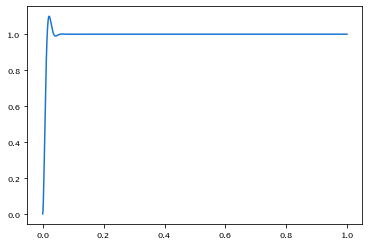

In [11]:
plt.plot(times, impulse)

In [5]:
times -= delay / f_sampling
impulse = impulse[times >= 0]
times = times[times >= 0]

In [6]:
combined = np.load('./combined.npy')[:4000]
residuals = np.vstack((np.load('./kalman_res_x.npy'), np.load('./kalman_res_y.npy'))).T
actions  = combined - residuals

true_actions = np.apply_along_axis(lambda row: np.convolve(row, impulse/sum(impulse))[:len(actions)], 
                                   axis=0, arr=actions)

In [7]:
'''if delay > 0:
    true_actions = np.apply_along_axis(lambda row: np.hstack((np.zeros(delay,), row[:-delay])),
                                   axis=0, arr=true_actions)'''
    
true_residuals = combined - true_actions

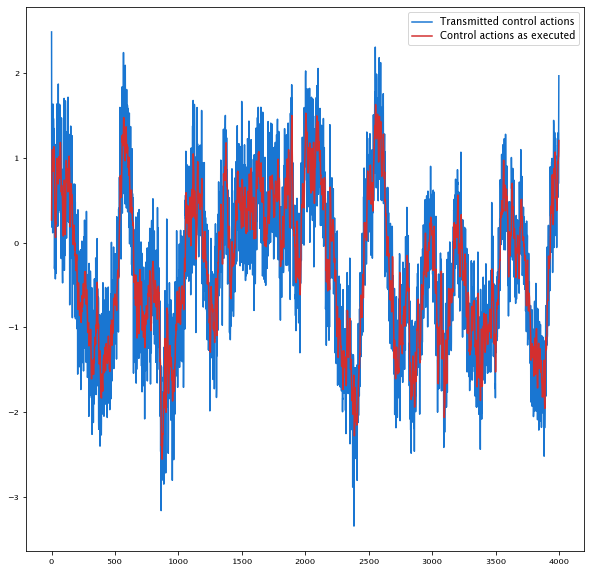

In [8]:
plt.figure(figsize=(10,10))
plt.plot(actions[:,0], label='Transmitted control actions')
plt.plot(true_actions[:,0], label='Control actions as executed')
#plt.plot(true_actions[:,0] - actions[:,0], label='Residual action')
plt.legend()

Text(0, 0.5, 'Deviation in y (mas)')

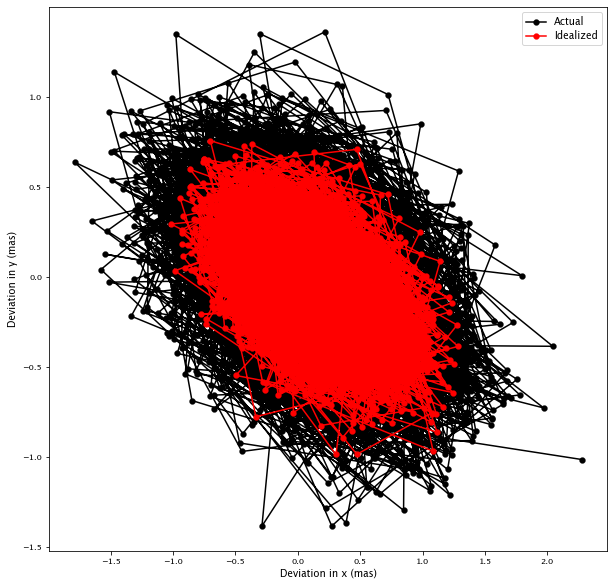

In [9]:
plt.figure(figsize=(10,10))
plt.plot(true_residuals[:,0], true_residuals[:,1], 'ko-', label='Actual')
plt.plot(residuals[:,0], residuals[:,1], 'ro-', label='Idealized')
plt.legend()
plt.xlabel("Deviation in x (mas)")
plt.ylabel("Deviation in y (mas)")

In [ ]:
plt.loglog()